In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'src/')
import acs5
import nyserda_acs
import prices
import project_sunroof
import nyserda
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import recall_score




%matplotlib inline

In [2]:
raw_data = nyserda_acs.merging_data()
raw_data=raw_data[raw_data['households']>0]

In [3]:
raw_data.shape

(4831, 157)

## Weights

In [4]:
#Duplicate positive rows
duplic = raw_data.loc[raw_data['Project_yes']==1,:]
duplic.loc[:,'Project_yes'] =0
duplic.loc[:,'Duplicate'] = 'Yes'
duplic.loc[:,'weight'] = (duplic.loc[:,'households']-duplic.loc[:,'Project_Number'])
duplic=duplic[duplic['weight']>0]
#Creating weights in old data
raw_data.loc[raw_data['Project_yes'] == 1, 'weight'] = raw_data['Project_Number']
raw_data.loc[raw_data['Project_yes'] == 0, 'weight'] = raw_data['households']
raw_data['Duplicate']='No'
#Merging data 
#Concatenating
all_data = raw_data.append(duplic, ignore_index=True)

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [5]:
all_data.shape

(6022, 159)

In [6]:
raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

7262279L

In [7]:
raw_data['Project_Number'].sum(axis=None, skipna=True, level=None, numeric_only=None)/raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

0.010750482045649858

## Columns

In [6]:
acs_percent_variables = ['Percent_Less_9th','Percent_more_than_hs', 'Percent_1_unit','Avg_hh_size',
                'Percent_hh_w_children', 'Percent_10+_units', 'Percent_Heating_electricity',
                'yearly_sunlight_kwh_total'  , 'Percent_6_rooms', 'percent_qualified',
                'Project_yes','weight','Duplicate']

## Simple model

In [7]:
df=all_data[acs_percent_variables]
df.describe()

,Percent_Less_9th,Percent_more_than_hs,Percent_1_unit,Avg_hh_size,Percent_hh_w_children,Percent_10+_units,Percent_Heating_electricity,yearly_sunlight_kwh_total,Percent_6_rooms,percent_qualified,Project_yes,weight
count,6022.000000,6022.000000,6022.000000,6016.000000,6022.000000,6022.000000,6022.000000,4.334000e+03,6022.000000,4334.000000,6022.000000,6022.000000
mean,0.061967,0.580089,0.519272,2.691910,0.284319,0.207292,0.097257,9.921398e+06,0.160951,73.957591,0.198273,1205.975590
std,0.063333,0.160649,0.329400,0.531699,0.096968,0.292366,0.099723,1.233842e+07,0.086711,13.109499,0.398732,908.509944
min,0.000000,0.000000,0.000000,1.030000,0.000000,0.000000,0.000000,2.178341e+03,0.000000,21.212121,0.000000,1.000000
25%,0.019415,0.462997,0.177321,2.350000,0.226530,0.009474,0.035761,3.022043e+06,0.094095,66.166192,0.000000,575.000000
50%,0.038274,0.572390,0.608207,2.610000,0.280668,0.059813,0.067727,5.319199e+06,0.166377,75.756407,0.000000,1176.500000
75%,0.082944,0.688009,0.805185,2.980000,0.341275,0.266650,0.121480,1.294382e+07,0.217519,83.435121,0.000000,1717.750000
max,0.445956,1.000000,1.000000,6.270000,1.000000,1.000000,1.000000,1.720241e+08,1.000000,100.000000,1.000000,12305.000000


In [8]:
df.shape

(6022, 13)

In [9]:
# Imputing missing values
df.loc[df['yearly_sunlight_kwh_total'].isnull(), 'yearly_sunlight_kwh_total'] = 0
df.loc[df['percent_qualified'].isnull(), 'percent_qualified'] = 200
df.loc[df['Avg_hh_size'].isnull(), 'Avg_hh_size']=np.mean(df.Avg_hh_size)

In [10]:
df.describe()

,Percent_Less_9th,Percent_more_than_hs,Percent_1_unit,Avg_hh_size,Percent_hh_w_children,Percent_10+_units,Percent_Heating_electricity,yearly_sunlight_kwh_total,Percent_6_rooms,percent_qualified,Project_yes,weight
count,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6022.000000,6.022000e+03,6022.000000,6022.000000,6022.000000,6022.000000
mean,0.061967,0.580089,0.519272,2.691910,0.284319,0.207292,0.097257,7.140375e+06,0.160951,109.287977,0.198273,1205.975590
std,0.063333,0.160649,0.329400,0.531434,0.096968,0.292366,0.099723,1.137619e+07,0.086711,57.698362,0.398732,908.509944
min,0.000000,0.000000,0.000000,1.030000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,21.212121,0.000000,1.000000
25%,0.019415,0.462997,0.177321,2.350000,0.226530,0.009474,0.035761,0.000000e+00,0.094095,70.092198,0.000000,575.000000
50%,0.038274,0.572390,0.608207,2.610000,0.280668,0.059813,0.067727,3.374421e+06,0.166377,81.747944,0.000000,1176.500000
75%,0.082944,0.688009,0.805185,2.980000,0.341275,0.266650,0.121480,8.996928e+06,0.217519,200.000000,0.000000,1717.750000
max,0.445956,1.000000,1.000000,6.270000,1.000000,1.000000,1.000000,1.720241e+08,1.000000,200.000000,1.000000,12305.000000


In [11]:
y=df['Project_yes']
weights=df['weight']
features=df.drop(['Project_yes', 'weight','Duplicate'], axis=1)


In [12]:
features.shape

(6022, 10)

## My score - AUC

In [13]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

# define scoring function 
def custom_auc(ground_truth, predictions):
    # I need only one column of predictions["0" and "1"]. You can get an error here
    # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

In [14]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(features, y, weights, test_size=0.3, random_state=42)

In [15]:
model = GradientBoostingClassifier()
search = GridSearchCV(model, param_grid = {'n_estimators' : [500, 1000, 2000], 'subsample' :[0.5,0.8],
                                           'max_depth': [2,3,4,5], 'learning_rate' : [0.1, 0.01, 0.001]}, 
                      scoring=my_auc, fit_params={'sample_weight': weights_train}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [16]:
fitted = search.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.604473, total=   1.1s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.580610, total=   1.1s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.570397, total=   1.1s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.604975, total=   1.3s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.595495, total=   1.3s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.554070, total=   1.2s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.587241, total=   2.3s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.563561, total=   2.5s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.564727, total=   2.4s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.581459, total=   2.5s
[CV] n_estimators=1000, subsample=0

[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.1, max_depth=4, score=0.497674, total=   8.2s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.1, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.1, max_depth=4, score=0.552648, total=   8.3s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5, score=0.592040, total=   2.2s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5, score=0.520806, total=   2.5s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5, score=0.521473, total=   2.5s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=5, score=0.580871, total=   2.4s
[CV] n_estimators=500, subsample=0.8,

[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.592936, total=   3.3s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.598155, total=   3.4s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.600139, total=   5.8s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.567052, total=   5.9s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.580633, total=   5.9s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.604064, total=   6.5s
[CV] n_estimators=2000

[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.627657, total=   1.3s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.631083, total=   1.3s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.643856, total=   1.2s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.628786, total=   2.3s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.610188, total=   2.3s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.633652, total=   2.2s
[CV] n_estimator

[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.001, max_depth=4, score=0.603317, total=   7.3s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.601251, total=   8.8s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.586974, total=   9.2s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.604847, total=   9.2s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5 
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5, score=0.571147, total=   2.5s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5 
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5, score=0.559254, total=   2.4s
[CV] n_estimato

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 16.1min finished


In [19]:
fitted.score(X_test, y_test)

0.75562360283159458

In [20]:
recall_score(y_test, fitted.predict(X_test))

0.0

In [21]:
fitted.best_params_

{'learning_rate': 0.001,
 'max_depth': 2,
 'n_estimators': 2000,
 'subsample': 0.8}

In [22]:
# Adding results to orginal Data Frames
df['result']=fitted.predict_proba(features)[:,1]

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
np.mean(df['result'])

0.02005980508546362

## ROC Curve

In [24]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8)

In [25]:
fitted = model.fit(X_train, y_train, sample_weight=weights_train)

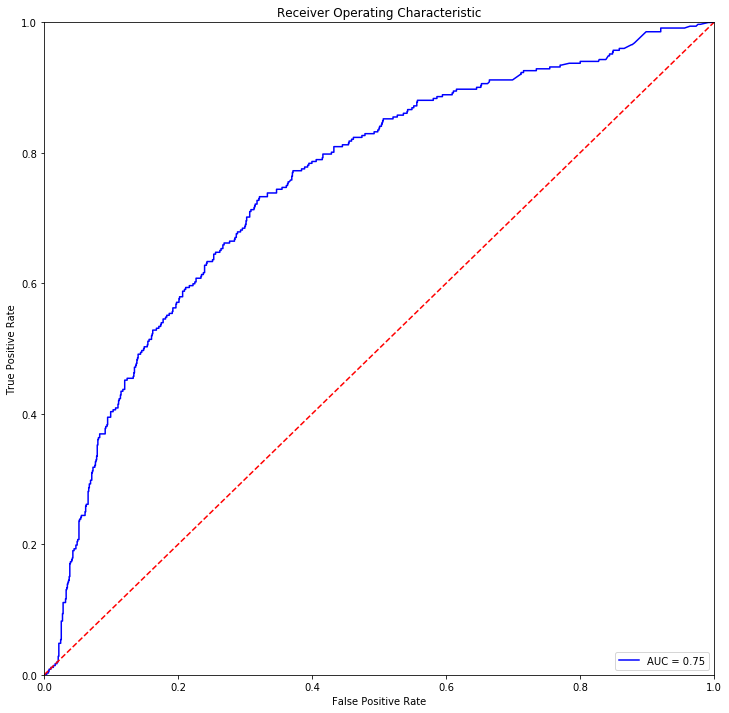

In [26]:
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = fitted.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
fig.savefig('roc_sep8.png')
plt.show()


## Feature importance

In [27]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.8)

In [28]:
fitted = model.fit(features, y, sample_weight=weights)

In [29]:
fitted.feature_importances_

array([ 0.10723793,  0.04884219,  0.26959572,  0.02838482,  0.01424682,
        0.12604903,  0.03881487,  0.17108052,  0.16959338,  0.02615471])

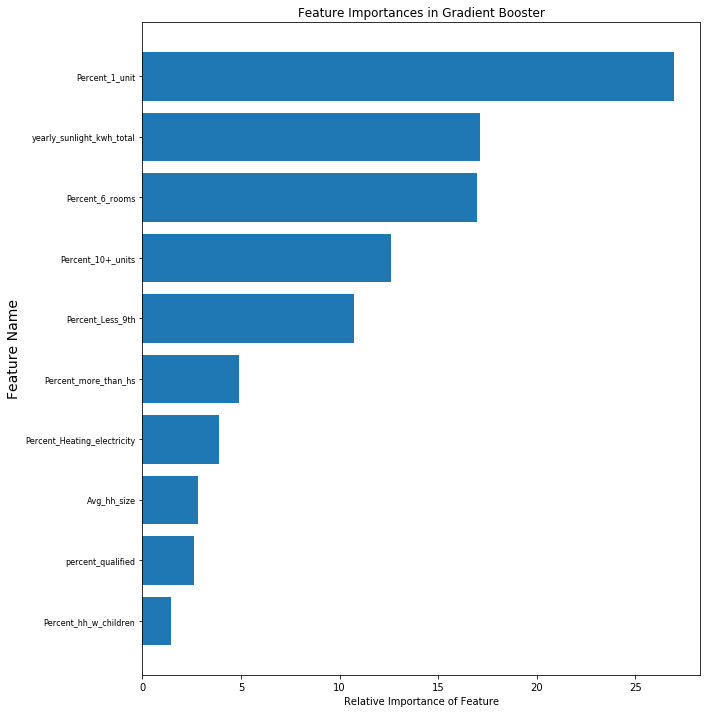

In [30]:
fitted.feature_importances_
feature_importances = 100*fitted.feature_importances_ / np.sum(fitted.feature_importances_)
feature_importances, feature_names, feature_idxs = zip(*sorted(zip(feature_importances, list(features.columns), range(len(features.columns)))))

width = 0.8

idx = np.arange(len(features.columns))

fig, ax = plt.subplots(figsize=(10,12))
ax.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names, fontsize=8)

ax.set_title("Feature Importances in Gradient Booster")
ax.set_xlabel('Relative Importance of Feature', fontsize=10)
ax.set_ylabel('Feature Name', fontsize=14)
fig.savefig('feat_imp_sep8.png')

## Saving data with results

In [31]:
result = fitted.predict_proba(features)[:,1]
raw_data['result']=result
raw_data[raw_data['Project_yes']==0]
raw_data[raw_data['Project_yes']==0].to_csv('output_sep11.csv')

In [32]:
np.median(result)

0.012390710470171686

In [44]:
N_ESTIMATORS = 500

In [ ]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=N_ESTIMATORS, subsample=0.8)
model.fit(X_train, y_train, sample_weight=weights_train)

train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
 

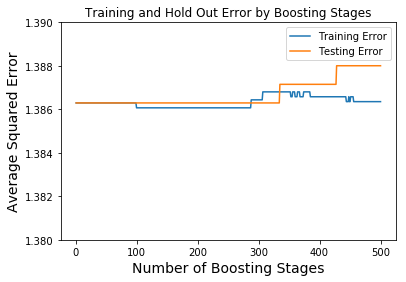

In [46]:
   
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
plt.ylim([1.38, 1.39])

plt.savefig('training-and-testing-error.png', bbox_inches='tight')